In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from numba import jit

<h3><b>Model Definition</b></h3>

<p>The model describes the <b>time-evolution</b> of the <b>relative distributions (concentrations)</b> of a <b>diffusing free morphogen</b> (i.e., GFP or mCherry-PNE), its <b>inhibitor</b> when applicable, and <b>a non-diffusing secondary signal</b> following the trapping of the free morphogen by
anchors.</p>
                                
<p>The base parameter values used in all simulations unless otherwise stated are: <b>D = 0.01, 𝑘𝜌𝑎 = 𝑘𝜌𝑖 = 1e-07, 𝑘𝑑𝑒𝑔= 0.02, 𝑘𝑠𝑟𝑐 𝑚 = 1.0</b>. A fixed off-rate was assumed for all inhibitors and anchors <b>𝑘𝑜𝑓𝑓 𝑖 = 𝑘𝑜𝑓𝑓 𝑎 = 2e-4</b>, and the corresponding on-rates where directly computed from the known dissociation constants <b>Kd as 𝑘𝑜𝑛 = 𝑘𝑜𝑓𝑓 / 𝐾𝑑</b>. </p>

<h3><b>Simulate the system using Euler's & Runge-Kutta (RK4) methods</b></h3>

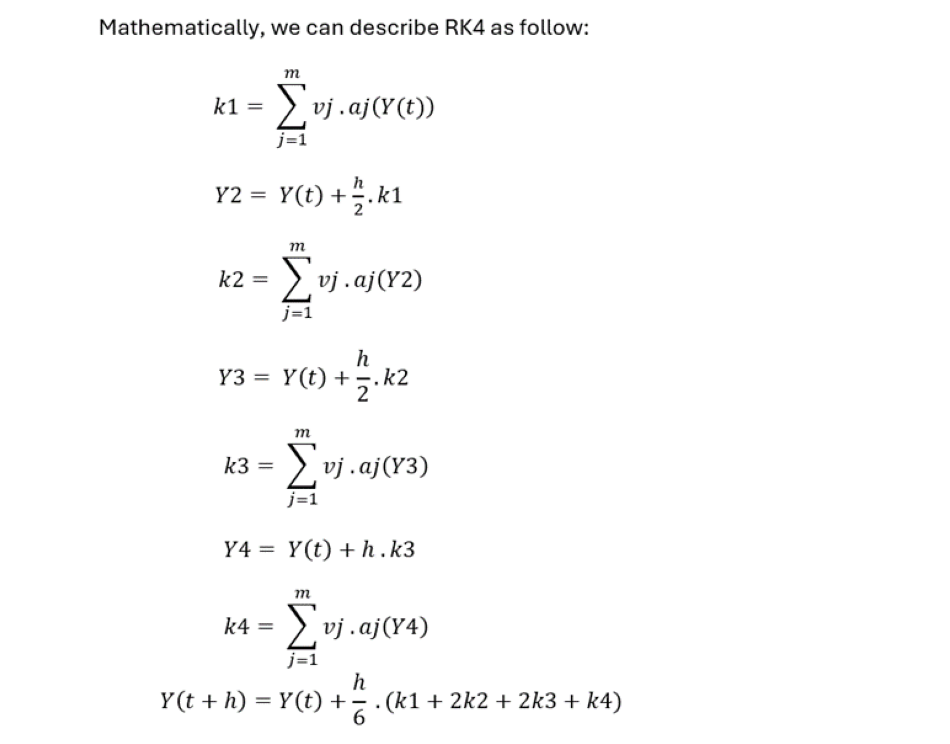

In [21]:
path = r"C:\Users\yda2\Desktop\master_project\runge_kutta.png"
img = mpimg.imread(path)
plt.figure(figsize=(12, 14))
plt.imshow(img)
plt.axis('off') 
plt.show()

In [22]:
#@jit
def initialize_species(fm_init, tm_init, fi_init, bi_init, start, stop, num_epochs):
    """
    Args:
        - fm_init: initial concentration of free morphogen, integer or float
        - tm_init: initial concentration of trapped morphogen, integer or float
        - fi_init: initial concentration of free inhibitor, integer or float
        - bi_init: initial concentration of bound inhibitor, integer of float
        - start: start time of the simulation, integer of float
        - stop: stop time of the simulation, integer or float
        - num_epochs: number of simulation epochs, integer
    Returns:
        - species: a dictionary contains initialized time and species arrays
    """
    time = np.linspace(start, stop, num_epochs)
    fM_conc = np.zeros(num_epochs)
    tM_conc = np.zeros(num_epochs)
    fI_conc = np.zeros(num_epochs)
    bI_conc = np.zeros(num_epochs)

    fM_conc[0] = fm_init
    tM_conc[0] = tm_init
    fI_conc[0] = fi_init
    bI_conc[0] = bi_init

    species = {
        "Simulation Time": time,
        "Free Morphogen": fM_conc,
        "Trapped Morphogen": tM_conc,
        "Free Inhibitor": fI_conc,
        "Bound Inhibitor": bI_conc
    }

    return species    

In [23]:
test1 = initialize_species(10, 100, 12, 32.2, 0.0, 10, 20)
print(test1)

{'Simulation Time': array([ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
        2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
        5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
        7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ]), 'Free Morphogen': array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'Trapped Morphogen': array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]), 'Free Inhibitor': array([12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'Bound Inhibitor': array([32.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])}


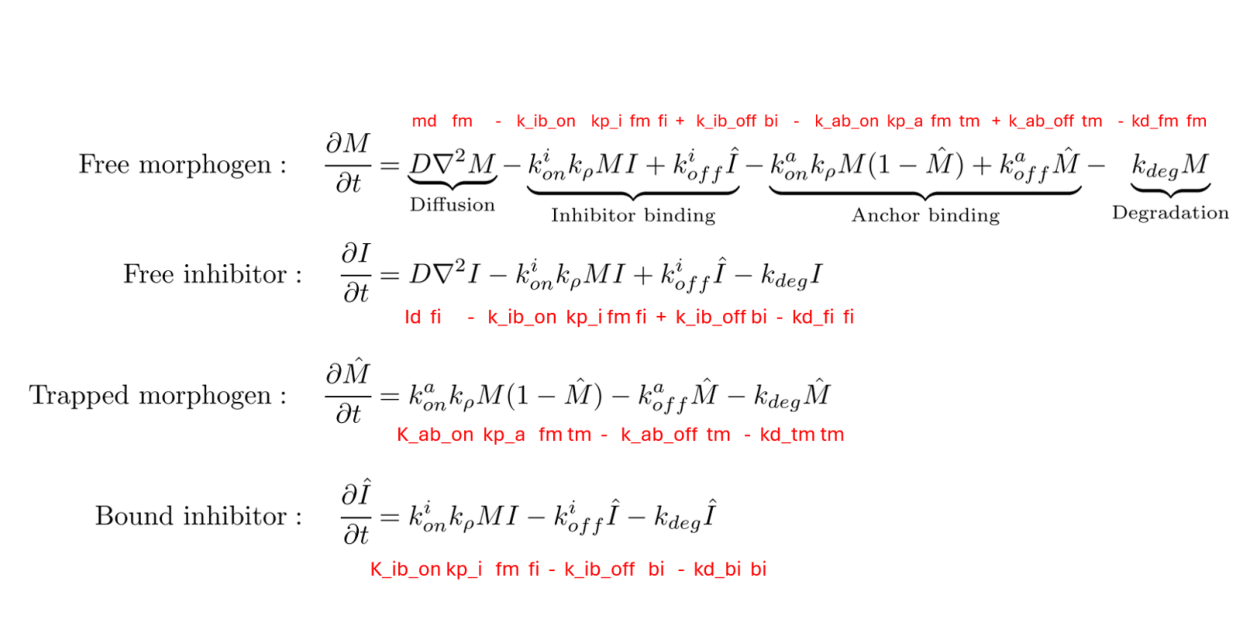

In [24]:
path = r"C:\Users\yda2\Desktop\master_project\equations.png"
img = mpimg.imread(path)
plt.figure(figsize=(16, 20))
plt.imshow(img)
plt.axis('off') 
plt.show()

In [25]:
#@jit
def compute_concentration_changes(fm, tm, fi, bi, cons): 
    """
    Args:
       - fm: free Morphogen concentration, integer or float
       - tm: trapped Morphogen concentration, integer or float
       - fi: free inhibitor concentration, integer or float
       - bi: bound inhibitor concentration, integer or float
       -cons: a dictionary contains rate constants for all reactions in the system
              k_fm: free Morphogen rate constant, integer or float
              k_fi: free Inhibitor rate constant, integer or float
              k_ib_on: inhibitr binding rate constant (on), integer or float
              k_ib_off: inhibitor binding rate constant (off), integer or float
              k_ab_on: anchor binding rate constant (on), integer or float
              k_ab_off: anchor binding rate constant (off), integer or float
              kd_fm: free morphogen degradation rate constant, integer or float
              kd_tm: trapped morphogen degradation rate constan, integer or float
              kd_fi: free inhibitor degradation rate constant, integer or float
              kd_bi: bound inhibitor degradation rate constant, integer or float
              kp_a: effective anchor concentration rate constant, integer or float
              kp_i: effective inhibitor concentration rate constant, integer or float
              md: morphogen diffusion rate constant, integer or float
              id: inhibitor diffusion rate constant, integer or float
    Returns:
       - d_fm: chnage in concentration of free morphogen, integer or float
       - d_fi: change in concentration of free inhibitor, integer or float
       - d_tm: change in concentration of trapped morphogen, integer or float
       - d_bi: change in concentration of bound inhibitor, integer or float                                       
    """
    d_fm = (cons["md"]*fm) - (cons["k_ib_on"]*cons["kp_i"]*fm*fi) + (cons["k_ib_off"]*bi) - (cons["k_ab_on"]*cons["kp_a"]*fm*(1-tm)) + (cons["k_ab_off"]*tm) + cons["kd_fm"]*fm
    d_fi = (cons["id"]*fi) - (cons["k_ib_on"]*cons["kp_i"]*fm*fi) + (cons["k_ib_off"]*bi) - (cons["kd_fi"]*fi)
    d_tm = (cons["k_ab_on"]*cons["kp_a"]*fm*(1-tm)) - (cons["k_ab_off"]*tm) - (cons["kd_tm"]*tm) 
    d_bi = (cons["k_ib_on"]*cons["kp_i"]*fm*fi) - (cons["k_ib_off"]*bi) - (cons["kd_bi"]*bi)
    
    return (d_fm, d_fi, d_tm, d_bi)


In [26]:
cons = {
    "k_fm": 0.01,
    "k_fi": 0.02, 
    "k_ib_on": 0.01,
    "k_ib_off": 2e-4,
    "k_ab_on": 0.01,
    "k_ab_off": 2e-4,
    "kd_fm": 0.02, 
    "kd_tm": 0.02, 
    "kd_fi": 0.02, 
    "kd_bi": 0.02,
    "kp_a": 1e-07,
    "kp_i": 1e-07,
    "md": 0.01,
    "id": 0.01
}

test2 = compute_concentration_changes(39, 12, 43, 12, cons)
print(test2)

(1.174798752, -0.42760167699999996, -0.242400429, -0.242398323)


In [27]:
#@jit
def compute_concentration_changes_rk4(fm, tm, fi, bi, cons, dt):
    """
    Args:
       - fm: free Morphogen concentration, integer or float
       - tm: trapped Morphogen concentration, integer or float
       - fi: free inhibitor concentration, integer or float
       - bi: bound inhibitor concentration, integer or float
       - cons: a dictionary contains rate constants for all reactions in the system
               k_fm: free Morphogen rate constant, integer or float
               k_fi: free Inhibitor rate constant, integer or float
               k_ib_on: inhibitor binding rate constant (on), integer or float
               k_ib_off: inhibitor binding rate constant (off), integer or float
               k_ab_on: anchor binding rate constant (on), integer or float
               k_ab_off: anchor binding rate constant (off), integer or float
               kd_fm: free morphogen degradation rate constant, integer or float
               kd_tm: trapped morphogen degradation rate constant, integer or float
               kd_fi: free inhibitor degradation rate constant, integer or float
               kd_bi: bound inhibitor degradation rate constant, integer or float
               kp_a: effective anchor concentration rate constant, integer or float
               kp_i: effective inhibitor concentration rate constant, integer or float
               md: morphogen diffusion rate constant, integer or float
               id: inhibitor diffusion rate constant, integer or float
       - dt: time step, float
    Returns:
       - d_fm: change in concentration of free morphogen, integer or float
       - d_fi: change in concentration of free inhibitor, integer or float
       - d_tm: change in concentration of trapped morphogen, integer or float
       - d_bi: change in concentration of bound inhibitor, integer or float
    """
    k1_fm, k1_fi, k1_tm, k1_bi = _compute_rates(fm, tm, fi, bi, cons)
    
    k2_fm, k2_fi, k2_tm, k2_bi = _compute_rates(fm + dt * k1_fm / 2, tm + dt * k1_tm / 2, 
                                                 fi + dt * k1_fi / 2, bi + dt * k1_bi / 2, cons)
    
    k3_fm, k3_fi, k3_tm, k3_bi = _compute_rates(fm + dt * k2_fm / 2, tm + dt * k2_tm / 2, 
                                                 fi + dt * k2_fi / 2, bi + dt * k2_bi / 2, cons)
    
    k4_fm, k4_fi, k4_tm, k4_bi = _compute_rates(fm + dt * k3_fm, tm + dt * k3_tm, 
                                                 fi + dt * k3_fi, bi + dt * k3_bi, cons)
    
    d_fm = (k1_fm + 2 * k2_fm + 2 * k3_fm + k4_fm) * dt / 6
    d_fi = (k1_fi + 2 * k2_fi + 2 * k3_fi + k4_fi) * dt / 6
    d_tm = (k1_tm + 2 * k2_tm + 2 * k3_tm + k4_tm) * dt / 6
    d_bi = (k1_bi + 2 * k2_bi + 2 * k3_bi + k4_bi) * dt / 6
    
    return (d_fm, d_fi, d_tm, d_bi)
#@jit
def _compute_rates(fm, tm, fi, bi, cons):
    """
    Helper function to compute rates for Runge-Kutta 4 method
    """
    d_fm = (cons["md"]*fm) - (cons["k_ib_on"]*cons["kp_i"]*fm*fi) + (cons["k_ib_off"]*bi) - (cons["k_ab_on"]*cons["kp_a"]*fm*(1-tm)) + (cons["k_ab_off"]*tm) + cons["kd_fm"]*fm
    d_fi = (cons["id"]*fi) - (cons["k_ib_on"]*cons["kp_i"]*fm*fi) + (cons["k_ib_off"]*bi) - (cons["kd_fi"]*fi)
    d_tm = (cons["k_ab_on"]*cons["kp_a"]*fm*(1-tm)) - (cons["k_ab_off"]*tm) - (cons["kd_tm"]*tm)
    d_bi = (cons["k_ib_on"]*cons["kp_i"]*fm*fi) - (cons["k_ib_off"]*bi) - (cons["kd_bi"]*bi)
    
    return d_fm, d_fi, d_tm, d_bi



In [28]:
cons = {
    "k_fm": 0.01,
    "k_fi": 0.02, 
    "k_ib_on": 0.01,
    "k_ib_off": 2e-4,
    "k_ab_on": 0.01,
    "k_ab_off": 2e-4,
    "kd_fm": 0.02, 
    "kd_tm": 0.02, 
    "kd_fi": 0.02, 
    "kd_bi": 0.02,
    "kp_a": 1e-07,
    "kp_i": 1e-07,
    "md": 0.01,
    "id": 0.01
}

test3 = compute_concentration_changes_rk4(39, 12, 43, 12, cons, 0.01)
print(test3)

(0.011749745044696317, -0.0042758054017192956, -0.002423759482224171, -0.0024237384224856475)


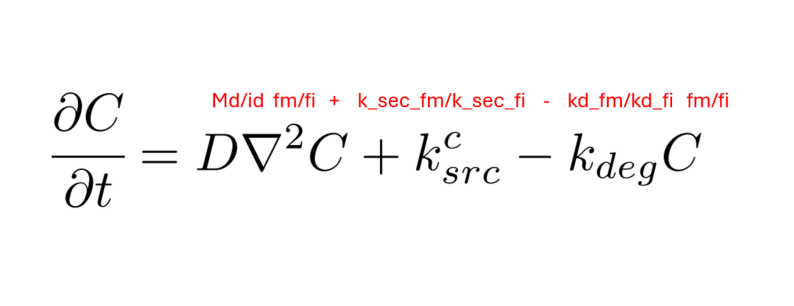

In [29]:
path = r"C:\Users\yda2\Desktop\master_project\sec_equations.png"
img = mpimg.imread(path)
plt.figure(figsize=(10, 14))
plt.imshow(img)
plt.axis('off') 
plt.show()

In [30]:
#@jit
def compute_secretion_changes(fm, fi, cons):
    """
    Args:
       - fm: free Morphogen concentration, integer or float
       - fi: free inhibitor concentration, integer or float
       -cons: a dictionary contains rate constants for all reactions in the system
              md: morphogen diffusion rate constant, integer or float
              id: inhibitor diffusion rate constant, integer or float
              k_sec_fm: free morphogen secretion rate, integer or float
              k_sec_fi: free inhibitor secretion rate, integer or float
              kd_fm: free morphogen degradation rate constant, integer or float
              kd_fi: free inhibitor degradation rate constant, integer or float
    Returns:
       - d_sec_fm: chnage in concentration of free morphogen, integer or float
       - d_sec_fi: change in concentration of free inhibitor, integer or float

    """
    d_sec_fm = (cons["md"]*fm) + cons["k_sec_fm"] - (cons["kd_fm"]*fm)
    d_sec_fi = (cons["id"]*fi) + cons["k_sec_fi"] - (cons["kd_fi"]*fi)
       
    return (d_sec_fm, d_sec_fi)

In [31]:
cons1 = {
    "kd_fm": 0.02, 
    "kd_fi": 0.02, 
    "k_sec_fm": 1.0, 
    "k_sec_fi": 1.0,
    "md": 0.01,
    "id": 0.01
}
test4 =  compute_secretion_changes(12, 14, cons1)
print(test4)

(0.8800000000000001, 0.8600000000000001)


In [32]:
#@jit
def compute_secretion_changes_rk4(fm, fi, cons, dt):
    """
    Args:
       - fm: free Morphogen concentration, integer or float
       - fi: free inhibitor concentration, integer or float
       - cons: a dictionary contains rate constants for all reactions in the system
              md: morphogen diffusion rate constant, integer or float
              id: inhibitor diffusion rate constant, integer or float
              k_sec_fm: free morphogen secretion rate, integer or float
              k_sec_fi: free inhibitor secretion rate, integer or float
              kd_fm: free morphogen degradation rate constant, integer or float
              kd_fi: free inhibitor degradation rate constant, integer or float
       - dt: time step, float
    Returns:
       - d_sec_fm: change in concentration of free morphogen, integer or float
       - d_sec_fi: change in concentration of free inhibitor, integer or float
    """
    k1_sec_fm, k1_sec_fi = _compute_secretion_rates(fm, fi, cons)
    k2_sec_fm, k2_sec_fi = _compute_secretion_rates(fm + dt * k1_sec_fm / 2, fi + dt * k1_sec_fi / 2, cons)
    k3_sec_fm, k3_sec_fi = _compute_secretion_rates(fm + dt * k2_sec_fm / 2, fi + dt * k2_sec_fi / 2, cons)
    k4_sec_fm, k4_sec_fi = _compute_secretion_rates(fm + dt * k3_sec_fm, fi + dt * k3_sec_fi, cons)
    
    d_sec_fm = (k1_sec_fm + 2 * k2_sec_fm + 2 * k3_sec_fm + k4_sec_fm) * dt / 6
    d_sec_fi = (k1_sec_fi + 2 * k2_sec_fi + 2 * k3_sec_fi + k4_sec_fi) * dt / 6
       
    return (d_sec_fm, d_sec_fi)

#@jit
def _compute_secretion_rates(fm, fi, cons):
    """
    Helper function to compute secretion rates for Runge-Kutta 4 method
    """
    d_sec_fm = (cons["md"]*fm) + cons["k_sec_fm"] - (cons["kd_fm"]*fm)
    d_sec_fi = (cons["id"]*fi) + cons["k_sec_fi"] - (cons["kd_fi"]*fi)
    
    return d_sec_fm, d_sec_fi


In [33]:
cons1 = {
    "kd_fm": 0.02, 
    "kd_fi": 0.02, 
    "k_sec_fm": 1.0, 
    "k_sec_fi": 1.0,
    "md": 0.01,
    "id": 0.01
}
test5 =  compute_secretion_changes_rk4(12, 14, cons1, 0.01)
print(test5)

(0.0087995600146663, 0.008599570014332975)


In [34]:
#@jit
def update_concentration(concentration_changes, secretion_changes, fM_conc, fI_conc, tM_conc, bI_conc, step):
    """
    Args:
        - concentration_changes: a tuple contains changes in concentration of species,
                                 d_fm: change in concentration of free morphogen, integer or float
                                 d_fi: change in concentration of free inhibitor, integer or float
                                 d_tm: change in concentration of trapped morphogen, integer or float
                                 d_bi: change in concentration of bound inhibitor, integer or float
                                 
        - secretion_changes: a tuple contains changes in concentration of species,
                             d_fm_sec: change in concentration of free morphogen, integer or float
                             d_fi_sec: change in concentration of free inhibitor, integer or float 
                        
        - fM_conc: an array contains free morpgogen specie concentration
        - fI_conc: an array contains free inhibitor specie concentration
        - tM_conc: an array contains trapped morphogen specie concentration
        - bI_conc: an array contains bound inhibitor specie concentration
        - step: the number of current simulation iteration (step), integer
    Returns:
        - fM_conc: updated free morpgogen specie concentration
        - fI_conc: updated free inhibitor specie concentration
        - tM_conc: updated trapped morphogen specie concentration
        - bI_conc: updated bound inhibitor specie concentration 
    """
    d_fm, d_fi, d_tm, d_bi = concentration_changes
    d_fm_sec, d_fi_sec = secretion_changes
    
    
    fM_conc[step] = fM_conc[step - 1] + d_fm + d_fm_sec
    fI_conc[step] = fI_conc[step - 1] + d_fi + d_fi_sec
    tM_conc[step] = tM_conc[step - 1] + d_tm
    bI_conc[step] = bI_conc[step - 1] + d_bi

    return (fM_conc, fI_conc, tM_conc, bI_conc)    

In [35]:
fM_conc = np.ones(10)
fI_conc = np.ones(10)
tM_conc = np.ones(10)
bI_conc = np.ones(10)
step = 5
print(fM_conc)
print(fI_conc)
print(tM_conc)
print(bI_conc)

test6 = update_concentration(test3, test4, fM_conc, fI_conc, tM_conc, bI_conc, step)
print(test6[0])
print(test6[1])
print(test6[2])
print(test6[-1])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.         1.         1.         1.         1.         1.89174975
 1.         1.         1.         1.        ]
[1.         1.         1.         1.         1.         1.85572419
 1.         1.         1.         1.        ]
[1.         1.         1.         1.         1.         0.99757624
 1.         1.         1.         1.        ]
[1.         1.         1.         1.         1.         0.99757626
 1.         1.         1.         1.        ]


In [36]:
#@jit
def simulation(fm_init, tm_init, fi_init, bi_init, constants, start, stop, epochs, method="euler"):
    """
    Args:
        - fm_init: initial concentration of free morphogen, integer or float
        - tm_init: initial concentration of trapped morphogen, integer or float
        - fi_init: initial concentration of free inhibitor, integer or float
        - bi_init: initial concentration of bound inhibitor, integer of float
        - constants: a dictionary contains rate constants for all reactions in the system
                     k_fm: free Morphogen rate constant, integer or float
                     k_fi: free Inhibitor rate constant, integer or float
                     k_sec_fm: free morphogen secretion rate, integer or float
                     k_sec_fi: free inhibitor secretion rate, integer or float
                     k_ib_on: inhibitr binding rate constant (on), integer or float
                     k_ib_off: inhibitor binding rate constant (off), integer or float
                     k_ab_on: anchor binding rate constant (on), integer or float
                     k_ab_off: anchor binding rate constant (off), integer or float
                     kd_fm: free morphogen degradation rate constant, integer or float
                     kd_tm: trapped morphogen degradation rate constan, integer or float
                     kd_fi: free inhibitor degradation rate constant, integer or float
                     kd_bi: bound inhibitor degradation rate constant, integer or float
                     kp: effective concentration rate constant, integer or float
                     md: morphogen diffusion rate constan, integer or float
                     id: inhibitor diffusion rate constant, integer or float
        - start: start time of the simulation, integer of float
        - stop: stop time of the simulation, integer or float
        - epochs: number of simulation iterations, integer
        - method: simulation's method, string
    Returns:
        - species: a dictionary containing the simulation time and the concentrations of the species after the simulation
        - simulation_duration: a float that defines the simulation duration    
    """
    
    simulation_duration = None
    dt = (stop - start) / epochs
    tic = time.time()

    species = initialize_species(
        fm_init=fm_init, 
        tm_init=tm_init, 
        fi_init=fi_init, 
        bi_init=bi_init, 
        start=start,
        stop=stop, 
        num_epochs=epochs
    )

    for i in range(1, epochs):
        
        if method == "euler":
            
            concentration_changes = compute_concentration_changes(
                fm=species["Free Morphogen"][i - 1], 
                tm=species["Trapped Morphogen"][i - 1], 
                fi=species["Free Inhibitor"][i - 1], 
                bi=species["Bound Inhibitor"][i - 1], 
                cons=constants
            )
            
            secretion_changes = compute_secretion_changes(
                fm=species["Free Morphogen"][i - 1], 
                fi=species["Free Inhibitor"][i - 1], 
                cons=constants
            )
        elif method == "rk4":

            concentration_changes = compute_concentration_changes_rk4(
                fm=species["Free Morphogen"][i - 1], 
                tm=species["Trapped Morphogen"][i - 1], 
                fi=species["Free Inhibitor"][i - 1], 
                bi=species["Bound Inhibitor"][i - 1], 
                cons=constants,
                dt=dt
            )
            
            secretion_changes = compute_secretion_changes_rk4(
                fm=species["Free Morphogen"][i - 1], 
                fi=species["Free Inhibitor"][i - 1], 
                cons=constants,
                dt=dt
            )
        else:
            raise("Wrong Simulation Method !!!")
        
        
        species["Free Morphogen"], species["Free Inhibitor"], species["Trapped Morphogen"], species["Bound Inhibitor"] = update_concentration(
            concentration_changes=concentration_changes,
            secretion_changes=secretion_changes,
            fM_conc=species["Free Morphogen"], 
            fI_conc=species["Free Inhibitor"],
            tM_conc=species["Trapped Morphogen"], 
            bI_conc=species["Bound Inhibitor"], 
            step= i
        )
    
    toc = time.time()
    simulation_duration = toc - tic
    
    return (species, simulation_duration)    

dict_keys(['Simulation Time', 'Free Morphogen', 'Trapped Morphogen', 'Free Inhibitor', 'Bound Inhibitor'])
0.005578279495239258
10
[0.         0.0004     0.00079178 0.00117552 0.00155136 0.00191948
 0.00228003 0.00263317 0.00297903 0.00331777]
[400.         392.0196     384.19880822 376.53443248 369.02334448
 361.66247844 354.44882993 347.3794546  340.45146698 333.66203932]
[1000.         1020.009599   1040.41939018 1061.23737737 1082.4717245
 1104.13075876 1126.22297389 1148.75703351 1171.74177451 1195.1862105 ]
[0.00000000e+00 1.00000000e-06 1.99980858e-06 2.99982976e-06
 4.00046739e-06 5.00212534e-06 6.00520764e-06 7.01011866e-06
 8.01726324e-06 9.02704691e-06]


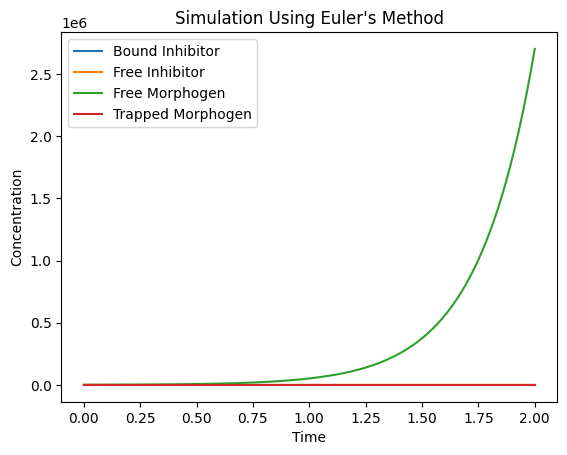

In [37]:
cons = {
    "k_fm": 0.01,
    "k_fi": 0.02,
    "k_sec_fm": .01,
    "k_sec_fi": 0.02,
    "k_ib_on": 0.01,
    "k_ib_off": 2e-4,
    "k_ab_on": 0.01,
    "k_ab_off": 2e-4,
    "kd_fm": 0.02, 
    "kd_tm": 0.02, 
    "kd_fi": 0.02, 
    "kd_bi": 0.02,
    "kp_a": 1e-07,
    "kp_i": 1e-07,
    "md": 0.01,
    "id": 0.01
}

test7 = simulation(1000, 0, 400, 0, cons, 0, 2, 400, "euler")
print(test7[0].keys())
print(test7[1])
print(len(test7[0]["Simulation Time"][:10]))
print(test7[0]["Bound Inhibitor"][:10])
print(test7[0]["Free Inhibitor"][:10])
print(test7[0]["Free Morphogen"][:10])
print(test7[0]["Trapped Morphogen"][:10])

plt.plot(test7[0]["Simulation Time"], test7[0]["Bound Inhibitor"], label="Bound Inhibitor")
plt.plot(test7[0]["Simulation Time"], test7[0]["Free Inhibitor"], label="Free Inhibitor")
plt.plot(test7[0]["Simulation Time"], test7[0]["Free Morphogen"], label="Free Morphogen")
plt.plot(test7[0]["Simulation Time"], test7[0]["Trapped Morphogen"], label="Trapped Morphogen")
plt.title("Simulation Using Euler's Method")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.legend()
plt.show()


dict_keys(['Simulation Time', 'Free Morphogen', 'Trapped Morphogen', 'Free Inhibitor', 'Bound Inhibitor'])
0.02448105812072754
10
[0.00000000e+00 1.99999900e-06 3.99979660e-06 5.99939283e-06
 7.99878770e-06 9.99798125e-06 1.19969735e-05 1.39957644e-05
 1.59943541e-05 1.79927425e-05]
[400.         399.960099   399.92020198 399.88030896 399.84041993
 399.80053488 399.76065383 399.72077676 399.68090368 399.64103458]
[1000.         1000.10006049 1000.200131   1000.30021151 1000.40030202
 1000.50040255 1000.60051309 1000.70063365 1000.80076421 1000.90090479]
[0.00000000e+00 5.00012250e-09 1.00002403e-08 1.50003535e-08
 2.00004620e-08 2.50005660e-08 3.00006655e-08 3.50007606e-08
 4.00008513e-08 4.50009376e-08]


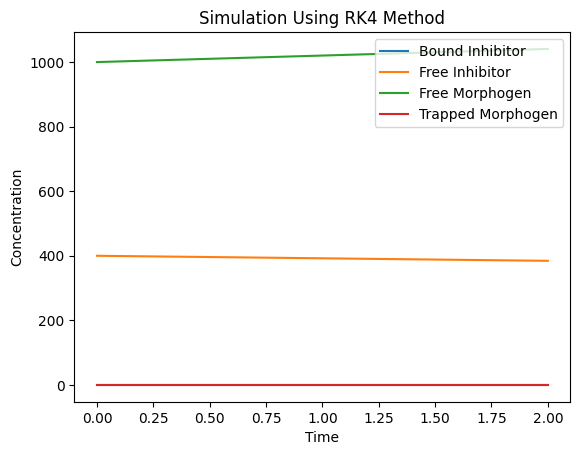

In [38]:
test8 = simulation(1000, 0, 400, 0, cons, 0, 2, 400, "rk4")
print(test8[0].keys())
print(test8[1])
print(len(test8[0]["Simulation Time"][:10]))
print(test8[0]["Bound Inhibitor"][:10])
print(test8[0]["Free Inhibitor"][:10])
print(test8[0]["Free Morphogen"][:10])
print(test8[0]["Trapped Morphogen"][:10])

plt.plot(test8[0]["Simulation Time"], test8[0]["Bound Inhibitor"], label="Bound Inhibitor")
plt.plot(test8[0]["Simulation Time"], test8[0]["Free Inhibitor"], label="Free Inhibitor")
plt.plot(test8[0]["Simulation Time"], test8[0]["Free Morphogen"], label="Free Morphogen")
plt.plot(test8[0]["Simulation Time"], test8[0]["Trapped Morphogen"], label="Trapped Morphogen")
plt.title("Simulation Using RK4 Method")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.legend()
plt.show()

In [102]:
cons = {
    "k_fm": 0.01,
    "k_fi": 0.02,
    "k_sec_fm": .01,
    "k_sec_fi": 0.02,
    "k_ib_on": 0.01,
    "k_ib_off": 2e-4,
    "k_ab_on": 0.01,
    "k_ab_off": 2e-4,
    "kd_fm": 0.02, 
    "kd_tm": 0.02, 
    "kd_fi": 0.02, 
    "kd_bi": 0.02,
    "kp_a": 1e-07,
    "kp_i": 1e-07,
    "md": 0.01,
    "id": 0.01
}

test8 = simulation(10000, 100000, 4000000, 100000, cons, 0, 1000, 100000000, "euler")
print(f"Simulate with Numba {test8[-1]} s")

UnsupportedError: Failed in nopython mode pipeline (step: nopython rewrites)
[1mDirectly raising a string constant as an exception is not supported.
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_6336\1214115680.py", line 82:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m